In [251]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy import constants
from scipy import signal
from scipy.ndimage import gaussian_filter1d
from scipy import interpolate

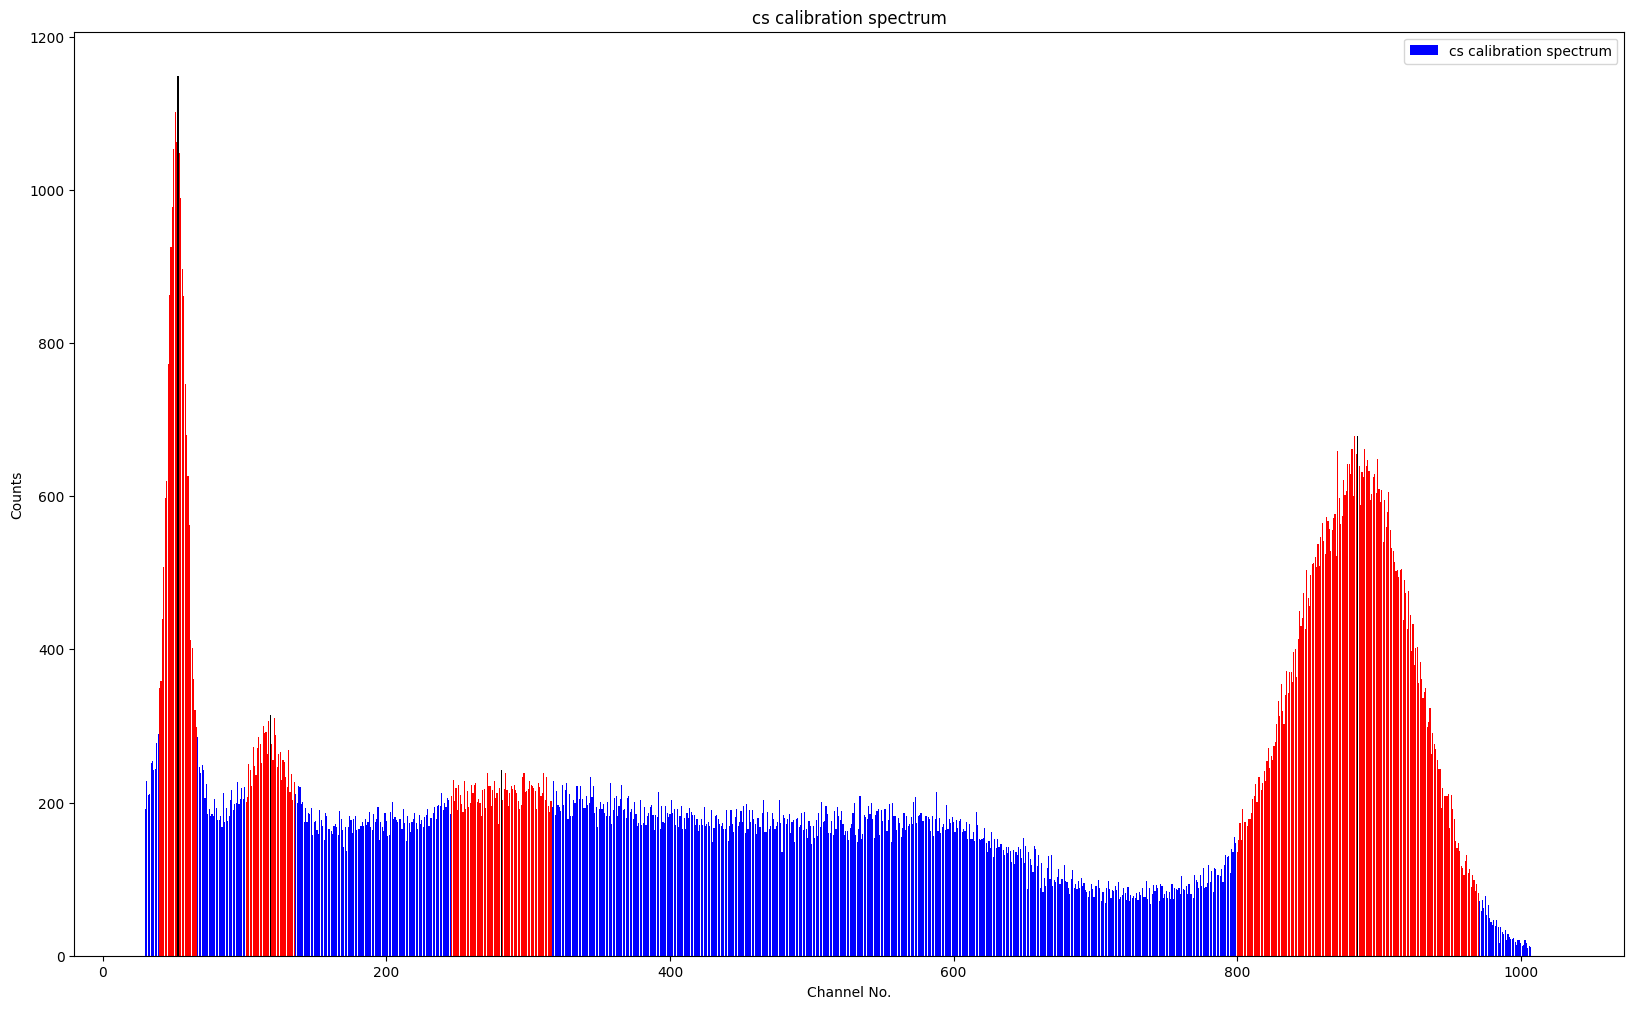

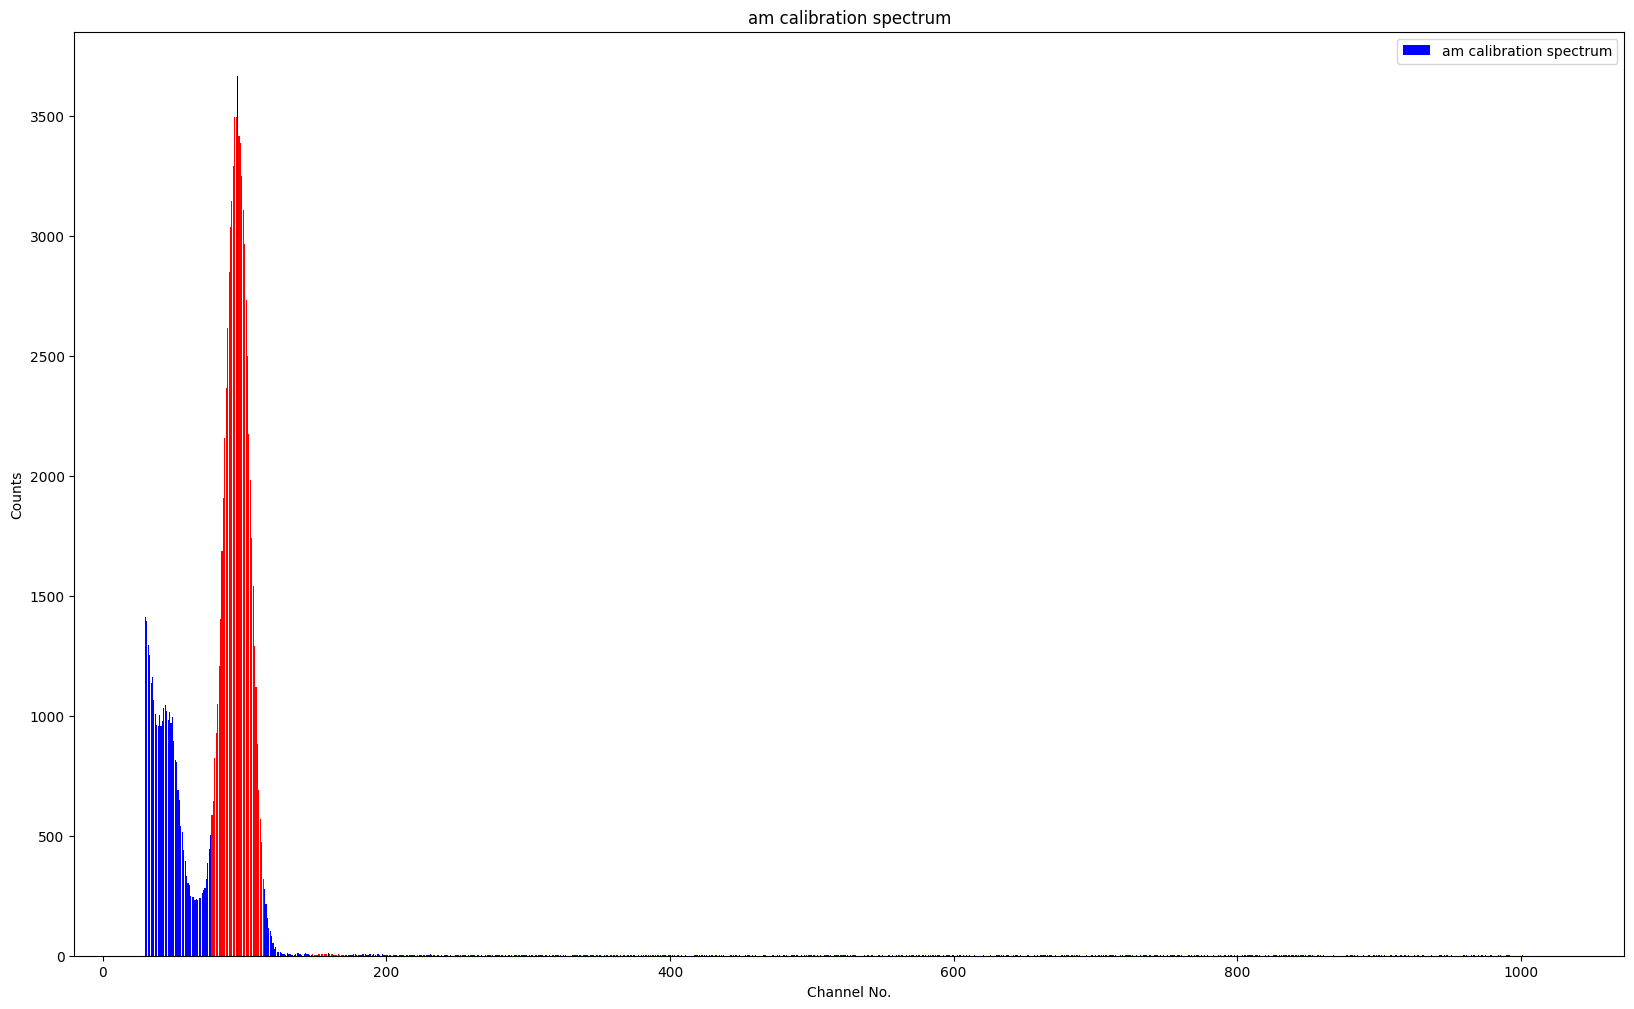

27.48430379746835
661.7
59.5


In [252]:
#calibration for the first part of the experiment
ignore_left=True
ignore=30
isotope="cs"
filepath = "/content/experiment_data/calibration_"+isotope+".txt"
data = pd.read_table(filepath)
counts_data = np.asarray(data["Counts"],dtype=int)
n_channels = np.arange(1024)

if ignore_left:
  counts_data = counts_data[ignore:]
  n_channels = n_channels[ignore:]

peaks, _ = signal.find_peaks(counts_data,width=10,distance=20)
peak_widths = signal.peak_widths(counts_data,peaks=peaks,rel_height=0.5)
whole_peaks = []
for i in range(len(n_channels)):
  for j in range(len(peaks)):
    if abs(i-peaks[j]) < peak_widths[0][j]:
      whole_peaks.append(i)


colors = []
for i in range(len(n_channels)):
  if i in peaks:
    colors.append('black')
  elif i in whole_peaks:
    colors.append('red')
  else:
    colors.append('blue')

fig, ax = plt.subplots(figsize=(20,12))
ax.bar(n_channels,counts_data, label=isotope+" calibration spectrum",color=colors)
#ax.set_yscale("log")
ax.set_xlabel("Channel No.")
ax.set_ylabel("Counts")
ax.set_title(isotope+" calibration spectrum")
ax.legend()
plt.show()

cs_channel = peaks[-1]+ignore
xray_channel = peaks[0]+ignore

isotope="am"
filepath = "/content/experiment_data/calibration_"+isotope+".txt"
data = pd.read_table(filepath)
counts_data = np.asarray(data["Counts"],dtype=int)
n_channels = np.arange(1024)

if ignore_left:
  counts_data = counts_data[ignore:]
  n_channels = n_channels[ignore:]

peaks, _ = signal.find_peaks(counts_data,width=10,distance=20)
peak_widths = signal.peak_widths(counts_data,peaks=peaks,rel_height=0.5)
whole_peaks = []
for i in range(len(n_channels)):
  for j in range(len(peaks)):
    if abs(i-peaks[j]) < peak_widths[0][j]:
      whole_peaks.append(i)


colors = []
for i in range(len(n_channels)):
  if i in peaks:
    colors.append('black')
  elif i in whole_peaks:
    colors.append('red')
  else:
    colors.append('blue')

fig, ax = plt.subplots(figsize=(20,12))
ax.bar(n_channels,counts_data, label=isotope+" calibration spectrum",color=colors)
#ax.set_yscale("log")
ax.set_xlabel("Channel No.")
ax.set_ylabel("Counts")
ax.set_title(isotope+" calibration spectrum")
ax.legend()
plt.show()
am_channel = peaks[0] + ignore

energy_part_1 = lambda channel: (cesium_gamma-americium_gamma) * (channel-am_channel)/(cs_channel-am_channel) + americium_gamma
print(energy_part_1(xray_channel))
print(energy_part_1(cs_channel))
print(energy_part_1(am_channel))

In [253]:
energies = (np.arange(10)+1)*100
sensitivities = np.array([100,93,85,77,71,67,63,60,58,56])/100
sensitivity_interpolate = interpolate.CubicSpline(energies,sensitivities)

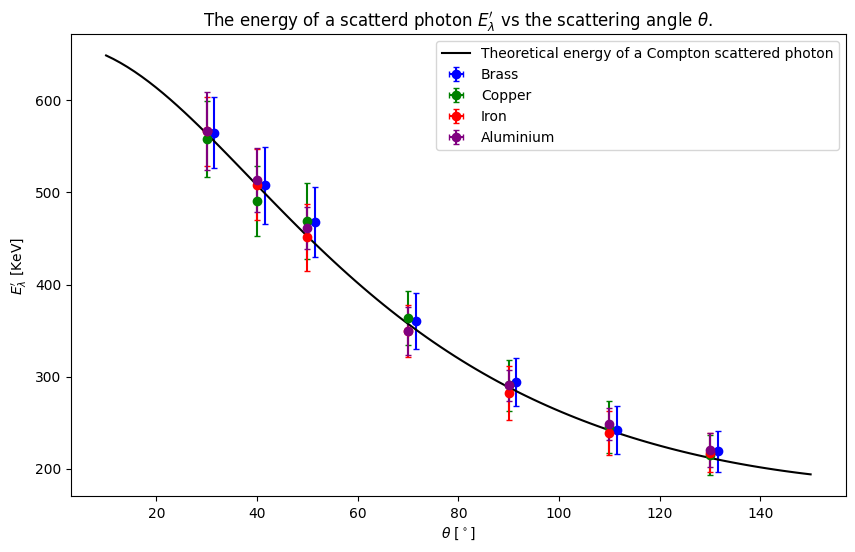

In [254]:
ignore_left=True
smooth_data = True
plot_intermediate_graphs = False
plot_compton_expression = True
account_for_sensitivities = True
ignore=50
sigma = 3.5

angle_error=0.1
angle_offsets=np.array([1.5,0,0,0])

peak_positions=[]
half_widths=[]

angle_errors = np.full((len(angles)),angle_error)

for i in range(4):
  material = materials[i]
  peaks_temp=[]
  widths_temp=[]
  for j in range(7):
    angle = angles[j]
    filepath = "/content/experiment_data/"+material+"_"+angle
    filepath_bck= filepath + "_bck.txt"
    filepath = filepath + ".txt"
    data = pd.read_table(filepath)
    data_bck = pd.read_table(filepath_bck)
    counts_data = np.asarray(data["Counts"],dtype=int)
    counts_bck = np.asarray(data_bck["Counts"],dtype=int)
    n_channels = np.arange(1024)

    if ignore_left:
      counts_data = counts_data[ignore:]
      counts_bck = counts_bck[ignore:]
      n_channels = n_channels[ignore:]
    data_corrected = counts_data - counts_bck

    if account_for_sensitivities:
      counts_data = counts_data / sensitivity_interpolate(energy_part_1(n_channels))
      counts_bck = counts_bck / sensitivity_interpolate(energy_part_1(n_channels))

    if smooth_data:
      data_corrected = gaussian_filter1d(data_corrected, sigma=sigma)
    peaks, _ = signal.find_peaks(data_corrected,width=40,distance=20,height=8)
    peak_widths = signal.peak_widths(data_corrected,peaks=peaks,rel_height=0.5)

    if plot_intermediate_graphs:
      whole_peaks = []
      for k in range(len(n_channels)):
        if abs(k-peaks[-1]) < peak_widths[0][-1]:
            whole_peaks.append(k)


      colors = []
      for k in range(len(n_channels)):
        if abs(k-peaks[-1])<5:
          colors.append('black')
        elif k in whole_peaks:
          colors.append('red')
        else:
          colors.append('blue')

      fig, ax = plt.subplots(figsize=(10,6))
      ax.bar(energy_part_1(n_channels),counts_data-counts_bck, color=colors)
      ax.set_xlabel("Energy [KeV]")
      ax.set_ylabel("Counts")
      ax.set_title(materials_names[i]+r" $\theta =$"+angles[j]+r"$^\circ$")
      plt.show()
    peaks_temp.append(peaks[-1]+ignore)
    widths_temp.append(peak_widths[0][-1]/2)
  peaks_temp = np.array(peaks_temp)
  widths_temp = np.array(widths_temp)
  peak_positions.append(peaks_temp)
  half_widths.append(widths_temp)
peak_positions = np.array(peak_positions)
half_widths = np.array(half_widths)
peak_positions = energy_part_1(peak_positions)
half_widths = (cesium_gamma - americium_gamma) / (cs_channel - am_channel) * half_widths

fig, ax = plt.subplots(figsize=(10,6))
for i in range(4):
  ax.errorbar(np.array(angles,dtype=float)+angle_offsets[i],peak_positions[i],xerr=angle_errors, yerr= half_widths[i], label=materials_names[i],fmt="o",capsize=2,c=material_colors[i])
if plot_compton_expression:
  ax.plot(angle_space,compton_energy(np.deg2rad(angle_space)),label=r"Theoretical energy of a Compton scattered photon",c="black")
ax.set_xlabel(r"$\theta$ [$^\circ$]")
ax.set_ylabel(r"$E_{\lambda}'$ [KeV]")
ax.set_title(r"The energy of a scatterd photon $E_{\lambda}'$ vs the scattering angle $\theta$.")
ax.legend()
plt.show()


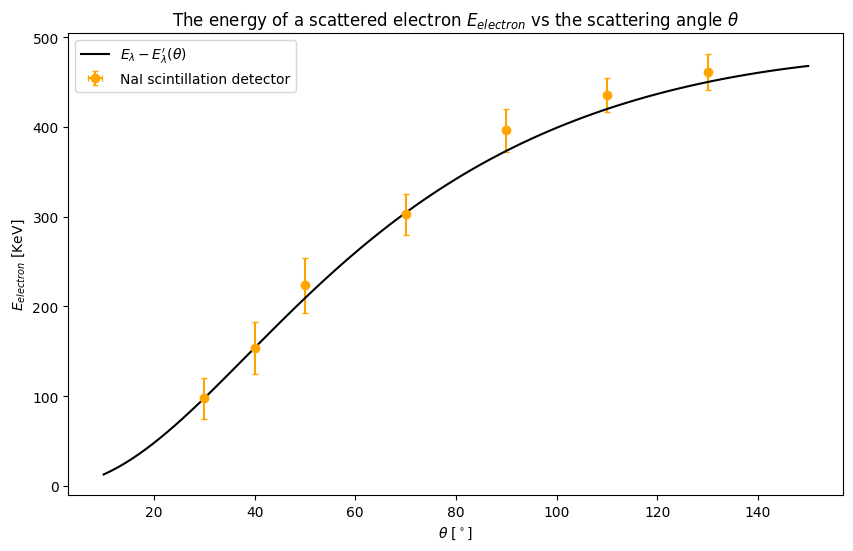

In [255]:
ignore_left=True
smooth_data = True
plot_intermediate_graphs = False
plot_compton_expression = True
ignore=50
sigma = 2

peak_positions=[]
half_widths=[]

angle_errors = np.full((len(angles)),angle_error)

photo_channel_2 = 119
am_channel_2 = 80
energy_part_2 = lambda channel: (116.15-americium_gamma) * (channel-am_channel_2)/(photo_channel_2-am_channel_2) + americium_gamma


material = "nai"
peaks_temp=[]
widths_temp=[]
for j in range(7):
  angle = angles[j]
  filepath = "/content/experiment_data/"+material+"_"+angle+".txt"
  data = pd.read_table(filepath)
  counts_data = np.asarray(data["Counts"],dtype=int)
  n_channels = np.arange(1024)

  if ignore_left:
    counts_data = counts_data[ignore:]
    n_channels = n_channels[ignore:]

  if smooth_data:
    data_corrected = gaussian_filter1d(counts_data, sigma=sigma)
  else:
    data_corrected = counts_data
  peaks, _ = signal.find_peaks(data_corrected,width=30,distance=20,height=8)
  peak_widths = signal.peak_widths(data_corrected,peaks=peaks,rel_height=0.5)

  if plot_intermediate_graphs:
    whole_peaks = []
    if len(peaks) !=0:
      for k in range(len(n_channels)):
        if abs(k-peaks[-1]) < peak_widths[0][-1]:
            whole_peaks.append(k)


      colors = []
      for k in range(len(n_channels)):
        if abs(k-peaks[-1])<5:
          colors.append('black')
        elif k in whole_peaks:
          colors.append('red')
        else:
          colors.append('blue')
    else:
      colors = np.full(len(n_channels),"blue")

    fig, ax = plt.subplots(figsize=(10,6))
    ax.bar(energy_part_1(n_channels),counts_data, color=colors)
    ax.set_xlabel("Energy [KeV]")
    ax.set_ylabel("Counts")
    ax.set_title(material+r" $\theta =$"+angles[j]+r"$^\circ$")
    plt.show()
  peaks_temp.append(peaks[-1]+ignore)
  widths_temp.append(peak_widths[0][-1]/2)
peaks_temp = np.array(peaks_temp)
widths_temp = np.array(widths_temp)
peak_positions=peaks_temp
half_widths=widths_temp

channel_1 = peak_positions[0]
channel_2 = peak_positions[1]
energy_part_2 = lambda channel: (compton_energy(np.deg2rad(30))-compton_energy(np.deg2rad(40))) * (channel-channel_1)/(channel_2-channel_1) + cesium_gamma - compton_energy(np.deg2rad(30))

peak_positions = energy_part_2(peak_positions)
half_widths = (compton_energy(np.deg2rad(30))-compton_energy(np.deg2rad(40))) / (channel_2-channel_1) * half_widths

fig, ax = plt.subplots(figsize=(10,6))
ax.errorbar(np.array(angles,dtype=float),peak_positions,xerr=angle_errors, yerr= half_widths, label="NaI scintillation detector",fmt="o",capsize=2,c=nai_color)
if plot_compton_expression:
  ax.plot(angle_space,cesium_gamma-compton_energy(np.deg2rad(angle_space)),label=r"$E_{\lambda} - E_{\lambda}'(\theta)$",c="black")
ax.set_xlabel(r"$\theta$ [$^\circ$]")
ax.set_ylabel(r"$E_{electron}$ [KeV]")
ax.set_title(r"The energy of a scattered electron $E_{electron}$ vs the scattering angle $\theta$")
ax.legend()
plt.show()

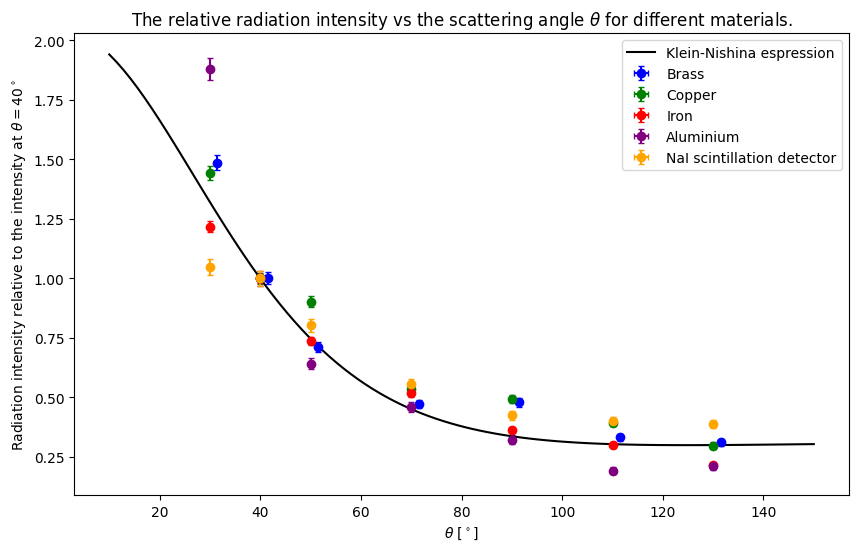

In [260]:
#canclulating and plottingradiation densioty per angle
ignore_left = True
plot_klein_nishina = True
plot_klein_nishina_integrated = False
ignore_accidental_counts = False
plot_materials_results = True
plot_nai_results = True
account_for_sensitivities = True

ignore = 50

angle_error=0.1
angle_offsets=np.array([1.5,0,0,0])

cesium_gamma = 661.7
americium_gamma = 59.5

material_colors = ['blue', 'green', 'red', 'purple']
nai_color = 'orange'

materials = ["brass","copper","fe","al"]
materials_names = ["Brass","Copper","Iron","Aluminium"]
angles = ["30","40","50","70","90","110","130"]

T_counting_value = 100
N1_array = np.array([3427,2780,2496,2197,2258,2297,2593])/T_counting_value
N2_value = 185779/T_counting_value
tau_value = 110 * 1e-9

compton_energy = lambda theta: cesium_gamma / (1 + cesium_gamma / constants.physical_constants["electron mass energy equivalent in MeV"][0] / 1000 * (1-np.cos(theta)))
klein_nishina = lambda theta: 1/2 * constants.physical_constants["classical electron radius"][0] **2 * (compton_energy(theta)/cesium_gamma)**2 * (compton_energy(theta)/cesium_gamma + cesium_gamma / compton_energy(theta) - np.sin(theta)**2)
klein_nishina_integrated = lambda theta: 2*np.pi*np.sin(theta)*klein_nishina(theta)

radiation_intensity = []
radiation_intensity_errors = []

angle_errors = np.full((len(angles)),angle_error)

for i in range(4):
  material = materials[i]
  intensity=[]
  intensity_error=[]
  for j in range(7):
    angle = angles[j]
    filepath = "/content/experiment_data/"+material+"_"+angle
    filepath_bck= filepath + "_bck.txt"
    filepath = filepath + ".txt"
    data = pd.read_table(filepath)
    data_bck = pd.read_table(filepath_bck)
    counts_data = np.asarray(data["Counts"],dtype=int)
    counts_bck = np.asarray(data_bck["Counts"],dtype=int)
    n_channels = np.arange(1024)
    if ignore_left:
      counts_data = counts_data[ignore:]
      counts_bck = counts_bck[ignore:]
      n_channels = n_channels[ignore:]
    if account_for_sensitivities:
      counts_data = counts_data / sensitivity_interpolate(energy_part_1(n_channels))
      counts_bck = counts_bck / sensitivity_interpolate(energy_part_1(n_channels))
    intensity.append(np.sum(counts_data)-np.sum(counts_bck))
    intensity_error.append(np.sqrt(np.sum(counts_data)+np.sum(counts_bck)))
  intensity = np.array(intensity)
  intensity_error = np.array(intensity_error)
  intensity_error = np.abs(intensity/intensity[1]) * np.sqrt((intensity_error/intensity)**2 + (intensity_error[1]/intensity[1])**2)
  intensity = intensity/intensity[1]
  radiation_intensity.append(intensity)
  radiation_intensity_errors.append(intensity_error)
radiation_intensity = np.array(radiation_intensity)
radiation_intensity_errors = np.array(radiation_intensity_errors)

accidental_counting_rates = 2*tau_value*N1_array*N2_value
accidental_counts = accidental_counting_rates * T_value

material="nai"
radiation_intensity_nai =[]
radiation_intensity_errors_nai=[]

for i in range(7):
  angle = angles[i]
  filepath = "/content/experiment_data/"+material+"_"+angle+".txt"
  data = pd.read_table(filepath)
  counts_data = np.asarray(data["Counts"],dtype=int)
  n_channels = np.arange(1024)
  if ignore_accidental_counts:
    radiation_intensity_nai.append(np.sum(counts_data))
    radiation_intensity_errors_nai.append(np.sqrt(np.sum(counts_data)))
  else:
    radiation_intensity_nai.append(np.sum(counts_data)-np.ceil(accidental_counts[i]))
    radiation_intensity_errors_nai.append(np.sqrt(np.sum(counts_data)+np.ceil(accidental_counts[i])))
radiation_intensity_nai = np.array(radiation_intensity_nai)
radiation_intensity_errors_nai = np.array(radiation_intensity_errors_nai)
radiation_intensity_errors_nai = radiation_intensity_nai/radiation_intensity_nai[1] * np.sqrt((radiation_intensity_errors_nai/radiation_intensity_nai)**2+ (radiation_intensity_errors_nai[1]/radiation_intensity_nai[1])**2)
radiation_intensity_nai = radiation_intensity_nai/radiation_intensity_nai[1]


angle_space = np.linspace(10,150,100)
fig, ax = plt.subplots(figsize=(10,6))
if plot_materials_results:
  for i in range(4):
    ax.errorbar(np.array(angles,dtype=float)+angle_offsets[i],radiation_intensity[i],xerr=angle_errors, yerr= radiation_intensity_errors[i], label=materials_names[i],fmt="o",capsize=2,c=material_colors[i])
if plot_nai_results:
  ax.errorbar(np.array(angles,dtype=float),radiation_intensity_nai,xerr=angle_errors, yerr= radiation_intensity_errors_nai, label="NaI scintillation detector",fmt="o",capsize=2,c=nai_color)
if plot_klein_nishina:
  ax.plot(angle_space,klein_nishina(np.deg2rad(angle_space))/klein_nishina(np.deg2rad(40)),label="Klein-Nishina espression",c="black")
if plot_klein_nishina_integrated:
  ax.plot(angle_space,klein_nishina_integrated(np.deg2rad(angle_space))/klein_nishina_integrated(np.deg2rad(40)),label=r"Klein-Nishina expression integrated over $\phi$",linestyle="dotted",c="black")
ax.set_xlabel(r"$\theta$ [$^\circ$]")
ax.set_ylabel(r"Radiation intensity relative to the intensity at $\theta = 40^\circ$")
ax.set_title(r"The relative radiation intensity vs the scattering angle $\theta$ for different materials.")
ax.legend()
plt.show()

